# Wahana Cerdas Chatbot

### Install Library

In [1]:
import random
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import json
import nltk
import time
import re
import swifter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import transformers
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification

from nltk.stem import WordNetLemmatizer
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model

from urllib import request

import warnings
warnings.filterwarnings("ignore")

'''# Package sentence tokenizer
nltk.download('punkt') 
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')'''

"# Package sentence tokenizer\nnltk.download('punkt') \n# Package lemmatization\nnltk.download('wordnet')\n# Package multilingual wordnet data\nnltk.download('omw-1.4')"

### Data Acquisition

In [2]:
url = "https://raw.githubusercontent.com/Handepp/Tugas-Akhir-Chatbot/main/Dataset/Data%20Wahana.json"
request.urlretrieve(url, "Data%20Wahana.json")

('Data%20Wahana.json', <http.client.HTTPMessage at 0x23b7dd51ee0>)

In [3]:
# Importing the dataset
with open('Data%20Wahana.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata 
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [4]:
# Cetak data keseluruhan
data

,patterns,tags
0,Siapa kamu?,Wardas.siapa
1,Kamu siapa?,Wardas.siapa
2,Ini apa?,Wardas.siapa
3,Kamu apa?,Wardas.siapa
4,Robot apakah kamu?,Wardas.siapa
...,...,...
258,Robot berhenti,wardas.stop
259,Wardas berhenti,wardas.stop
260,Diam,wardas.stop
261,Cukup diam,wardas.stop


In [5]:
data.tags.value_counts()

Wardas.siapa          15
wardas.buruk          12
wardas.sapa           11
wardas.hobby          10
wardas.usia           10
wardas.benar          10
wardas.stop           10
wardas.mundur          9
wardas.ngobrol         9
wardas.maju            9
wardas.insaf           9
wardas.suhu            9
wardas.hump            9
wardas.asal            9
wardas.siap            8
wardas.hari            7
wardas.Baterai         7
wardas.fast            7
wardas.medium          7
wardas.slow            7
wardas.beban           7
wardas.tanggal         7
wardas.terimakasih     7
wardas.lokasi          7
wardas.bos             7
wardas.bantu           7
wardas.jam             6
wardas.berpisah        6
wardas.malam           5
wardas.sore            5
wardas.pagi            5
wardas.siang           5
wardas.baik            5
Name: tags, dtype: int64

In [6]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

33 classes ['Wardas.siapa', 'wardas.Baterai', 'wardas.asal', 'wardas.baik', 'wardas.bantu', 'wardas.beban', 'wardas.benar', 'wardas.berpisah', 'wardas.bos', 'wardas.buruk', 'wardas.fast', 'wardas.hari', 'wardas.hobby', 'wardas.hump', 'wardas.insaf', 'wardas.jam', 'wardas.lokasi', 'wardas.maju', 'wardas.malam', 'wardas.medium', 'wardas.mundur', 'wardas.ngobrol', 'wardas.pagi', 'wardas.sapa', 'wardas.siang', 'wardas.siap', 'wardas.slow', 'wardas.sore', 'wardas.stop', 'wardas.suhu', 'wardas.tanggal', 'wardas.terimakasih', 'wardas.usia']


### Preprocessing

In [7]:
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  #text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces
  return text

In [8]:
key= "https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv"
request.urlretrieve(key, "key_norm.csv")
key_norm = pd.read_csv('key_norm.csv')
print(key_norm.head())

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


In [9]:
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

In [10]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [11]:
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = stemming(text)
  return text

In [12]:
%%time
data['patterns'] = data['patterns'].swifter.apply(text_preprocessing_process)

Pandas Apply:   0%|          | 0/263 [00:00<?, ?it/s]

CPU times: total: 10.3 s
Wall time: 10.5 s


In [13]:
data

,patterns,tags
0,siapa kamu,Wardas.siapa
1,kamu siapa,Wardas.siapa
2,ini apa,Wardas.siapa
3,kamu apa,Wardas.siapa
4,robot apakah kamu,Wardas.siapa
...,...,...
258,robot henti,wardas.stop
259,wardas henti,wardas.stop
260,diam,wardas.stop
261,cukup diam,wardas.stop


## BERT

In [14]:
labelencoder = LabelEncoder()
data['tags'] = labelencoder.fit_transform(data['tags'])

In [15]:
df_train, df_test = train_test_split(data, test_size=0.25)
df_val, df_test = train_test_split(df_test, test_size=0.25)

df_train.shape, df_test.shape, df_val.shape

((197, 2), (17, 2), (49, 2))

In [16]:
# Tentukan pre-trained model yang akan digunakan untuk fine-tuning
# Daftar model dapat ditemukan pada https://huggingface.co

PRE_TRAINED_MODEL = 'indobenchmark/indobert-base-p2'  # https://huggingface.co/indobenchmark/indobert-base-p2
bert_tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)  # Load tokenizer dari pre-trained model
vocabulary = bert_tokenizer.get_vocab()

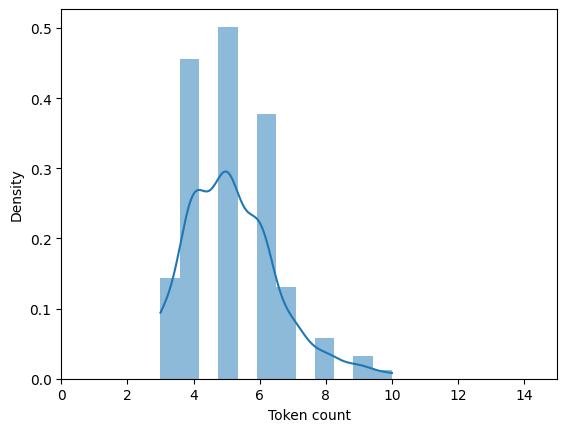

In [17]:
token_lens = []

for txt in data.patterns:
  tokens = bert_tokenizer.encode(txt)
  token_lens.append(len(tokens))

sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 15]);
plt.xlabel('Token count');

In [18]:
MAX_LEN = 11

In [19]:
def convert_example_to_feature(sentence):  
  return bert_tokenizer.encode_plus(
      sentence, 
      add_special_tokens = True, 
      padding = 'max_length',
      truncation = 'longest_first',
      max_length = MAX_LEN, 
      return_attention_mask = True, 
      return_token_type_ids=True
    )

def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,               # Sebagai token embedding
      "token_type_ids": token_type_ids,     # Sebagai segment embedding
      "attention_mask": attention_masks,    # Sebagai filter informasi mana yang kalkulasi oleh model
  }, label

# Buat fungsi untuk iterasi pada setiap kalimat pada keseluruhan data
def encode(data):
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
    
  for sentence, label in data.to_numpy():

    bert_input = convert_example_to_feature(sentence)
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [20]:
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 5e-5

In [21]:
# Lakukan input formatting menggunakan fungsi sebelumnya pada data keseluruhan data
train_encoded = encode(df_train).batch(BATCH_SIZE)
test_encoded = encode(df_test).batch(BATCH_SIZE)
val_encoded = encode(df_val).batch(BATCH_SIZE)

In [22]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=33)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Karena tidak menggunakan one-hot vectors, sehingga loss function dapat menggunakan sparse categorical cross entropy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile model
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
%%time
bert_history = bert_model.fit(train_encoded, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_encoded)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\hande\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\hande\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "C:\Users\hande\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 728, in start
      self.io_loop.start()
    File "C:\Users\hande\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\hande\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\hande\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\hande\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\hande\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\hande\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 423, in do_execute
      res = shell.run_cell(
    File "C:\Users\hande\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\hande\AppData\Local\Temp\ipykernel_13868\376197097.py", line 1, in <module>
      get_ipython().run_cell_magic('time', '', 'bert_history = bert_model.fit(train_encoded, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_encoded)\n')
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 2422, in run_cell_magic
      result = fn(*args, **kwargs)
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\magics\execution.py", line 1316, in time
      exec(code, glob, local_ns)
    File "<timed exec>", line 1, in <module>
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\modeling_tf_utils.py", line 1529, in train_step
      loss = self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 2098, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\Users\hande\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py", line 5633, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 32 which is outside the valid range of [0, 32).  Label values: 2 7 9 5 10 11 8 11 17 12 14 28 23 21 24 19 16 6 13 4 13 1 13 28 32 25 15 10 25 12 0 16
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_37599]

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

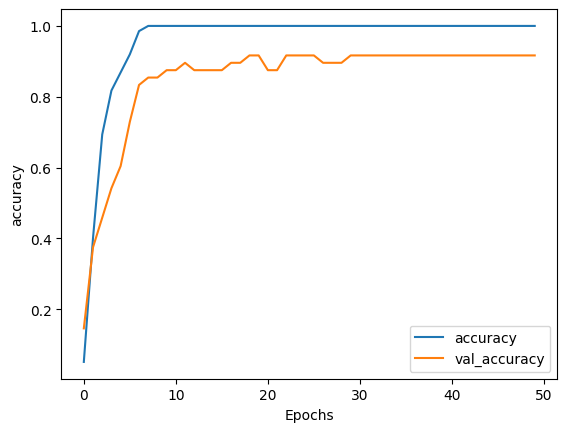

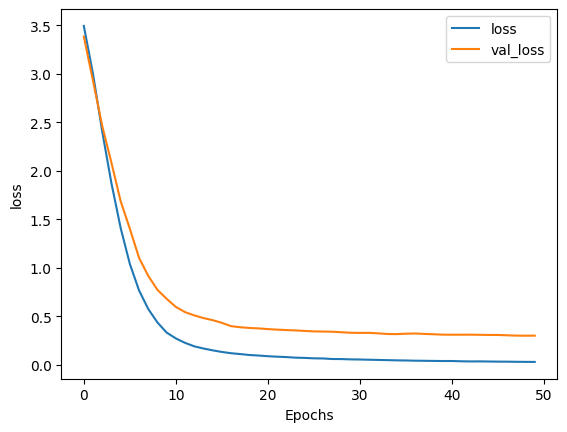

In [ ]:
plot_graphs(bert_history, 'accuracy')
plot_graphs(bert_history, 'loss')

In [ ]:
bert_model.save_weights('Model/bert-wardas.h5')

In [ ]:
score = bert_model.evaluate(test_encoded)

print("Test Accuracy:", score[1])

1/1 [==============================] - 1s 1s/step - loss: 0.3795 - accuracy: 0.8846
Test Accuracy: 0.8846153616905212
